# Pipeline de Análise de Segurança Automatizada (AIOps)
## Detecção de Componentes em Diagramas de Arquitetura + Análise STRIDE

Este notebook implementa um sistema completo de análise de segurança usando visão computacional para detectar componentes em diagramas de arquitetura e gerar relatórios STRIDE automatizados.

## 1. Configuração do Ambiente

In [ ]:
# Verificar GPU disponível
import torch
print(f"CUDA disponível: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memória GPU: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("⚠️ GPU não detectada. O treinamento será mais lento.")

CUDA disponível: True
GPU: Tesla T4
Memória GPU: 14.74 GB


In [ ]:
# Instalar dependências
!pip install ultralytics kaggle kagglehub opencv-python-headless pandas matplotlib gradio reportlab networkx -q

In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Criar diretórios de trabalho
import os
WORK_DIR = '/content/drive/MyDrive/security_analysis'
MODELS_DIR = os.path.join(WORK_DIR, 'models')
REPORTS_DIR = os.path.join(WORK_DIR, 'reports')
DATA_DIR = '/content/dataset'

os.makedirs(WORK_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

print(f"✅ Diretórios criados em: {WORK_DIR}")

Mounted at /content/drive
✅ Diretórios criados em: /content/drive/MyDrive/security_analysis


In [ ]:
# Configurar autenticação Kaggle (Opcional mas recomendado)
# NOTA: kagglehub pode funcionar sem autenticação para datasets públicos,
# mas a autenticação é recomendada para evitar limites de rate e acessar datasets privados

# Método 1: Upload manual do kaggle.json
from google.colab import files
import json
import shutil

print("📤 Faça upload do arquivo kaggle.json (ou pressione Cancel para pular):")
print("   Nota: Para datasets públicos, você pode pular esta etapa.")
uploaded = files.upload()

# Mover para o local correto
if uploaded:
    for fn in uploaded.keys():
        if 'kaggle.json' in fn:
            os.makedirs('/root/.kaggle', exist_ok=True)
            shutil.move(fn, '/root/.kaggle/kaggle.json')
            os.chmod('/root/.kaggle/kaggle.json', 600)
            print("✅ kaggle.json configurado com sucesso!")
            break
else:
    print("⚠️ Autenticação não configurada. Usando modo público (pode ter limites de rate).")

# Alternativa: Usar Secrets do Colab
# from google.colab import userdata
# try:
#     kaggle_username = userdata.get('KAGGLE_USERNAME')
#     kaggle_key = userdata.get('KAGGLE_KEY')
#     os.makedirs('/root/.kaggle', exist_ok=True)
#     with open('/root/.kaggle/kaggle.json', 'w') as f:
#         json.dump({'username': kaggle_username, 'key': kaggle_key}, f)
#     os.chmod('/root/.kaggle/kaggle.json', 600)
#     print("✅ Autenticação configurada via Secrets do Colab!")
# except:
#     print("⚠️ Secrets não configurados. Usando modo público.")

📤 Faça upload do arquivo kaggle.json:


Saving kaggle.json to kaggle.json
✅ kaggle.json configurado com sucesso!


## 2. Download e Exploração do Dataset

In [7]:
# Baixar dataset do Kaggle usando kagglehub
import kagglehub

print("📥 Baixando dataset do Kaggle...")
# kagglehub.dataset_download retorna o caminho onde o dataset foi baixado
dataset_path = kagglehub.dataset_download("carlosrian/software-architecture-dataset")

print(f"✅ Dataset baixado em: {dataset_path}")

# Se o dataset já estiver extraído, usar diretamente
# Caso contrário, pode precisar descompactar
import os
if os.path.isdir(dataset_path):
    # Dataset já está extraído, criar link simbólico ou copiar para DATA_DIR
    import shutil
    # Copiar conteúdo para DATA_DIR para manter compatibilidade
    if os.path.exists(DATA_DIR):
        shutil.rmtree(DATA_DIR)
    shutil.copytree(dataset_path, DATA_DIR)
    print(f"✅ Dataset copiado para: {DATA_DIR}")
else:
    # Se for um arquivo zip, descompactar
    import zipfile
    if dataset_path.endswith('.zip'):
        with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
            zip_ref.extractall(DATA_DIR)
        print(f"✅ Dataset extraído para: {DATA_DIR}")
    else:
        # Se já for um diretório, usar diretamente
        DATA_DIR = dataset_path
        print(f"✅ Usando dataset diretamente de: {DATA_DIR}")

print("✅ Dataset pronto para uso!")

📥 Baixando dataset do Kaggle...


100%|██████████| 30.5G/30.5G [05:14<00:00, 104MB/s]

Extracting files...


✅ Dataset baixado em: /root/.cache/kagglehub/datasets/carlosrian/software-architecture-dataset/versions/1


KeyboardInterrupt: 

In [9]:
# Explorar estrutura do dataset
!ls -la {DATA_DIR}
print("\n")
!find {DATA_DIR} -type d -maxdepth 2 | head -20

total 12
drwxr-xr-x 3 root root 4096 Feb  9 17:59 .
drwxr-xr-x 1 root root 4096 Feb  9 17:59 ..
drwxr-xr-x 3 root root 4096 Feb  9 17:59 src


find: warning: you have specified the global option -maxdepth after the argument -type, but global options are not positional, i.e., -maxdepth affects tests specified before it as well as those specified after it.  Please specify global options before other arguments.
/content/dataset
/content/dataset/src
/content/dataset/src/dataset


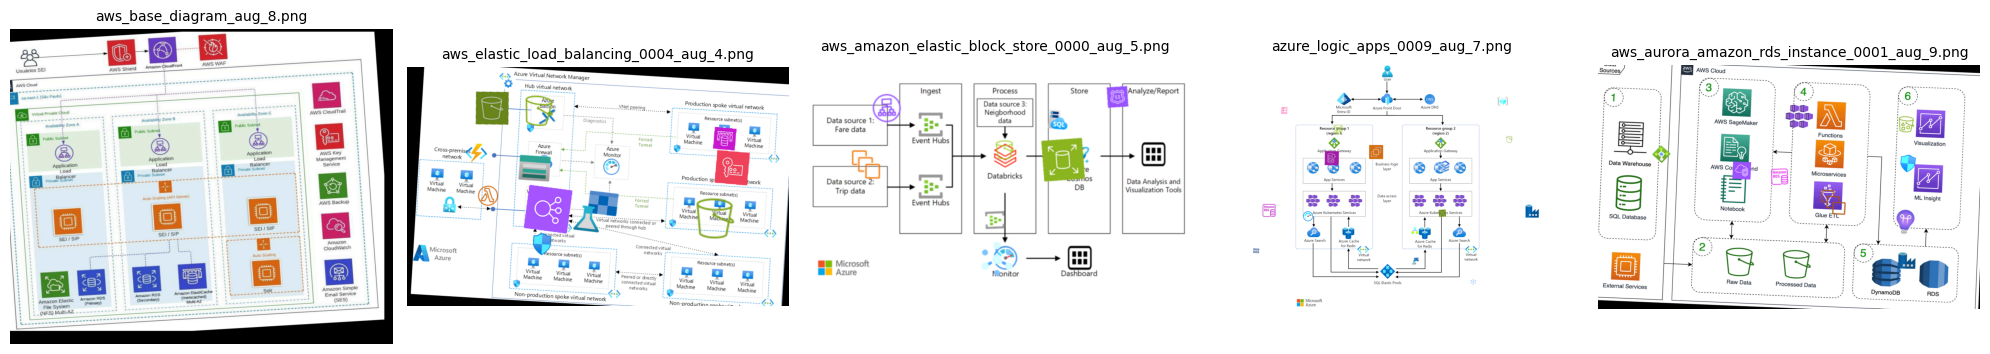

In [10]:
# Visualizar imagens e anotações
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
import random

def visualize_dataset(data_dir, num_samples=5):
    """Visualiza imagens do dataset com suas bounding boxes"""
    # Procurar por imagens e anotações
    images_path = Path(data_dir)

    # Tentar encontrar estrutura comum
    img_files = list(images_path.rglob('*.jpg')) + list(images_path.rglob('*.png'))

    if not img_files:
        print("⚠️ Nenhuma imagem encontrada. Verificando estrutura...")
        return

    # Selecionar amostras aleatórias
    sample_images = random.sample(img_files, min(num_samples, len(img_files)))

    fig, axes = plt.subplots(1, len(sample_images), figsize=(20, 4))
    if len(sample_images) == 1:
        axes = [axes]

    for idx, img_path in enumerate(sample_images):
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[idx].imshow(img_rgb)
        axes[idx].set_title(f"{img_path.name}", fontsize=10)
        axes[idx].axis('off')

        # Tentar carregar anotações correspondentes
        # Formato comum: YOLO (.txt) ou COCO (.json)
        txt_path = img_path.with_suffix('.txt')
        if txt_path.exists():
            with open(txt_path, 'r') as f:
                lines = f.readlines()
                h, w = img_rgb.shape[:2]
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id, x_center, y_center, width, height = map(float, parts[:5])
                        # Converter de formato YOLO para coordenadas absolutas
                        x1 = int((x_center - width/2) * w)
                        y1 = int((y_center - height/2) * h)
                        x2 = int((x_center + width/2) * w)
                        y2 = int((y_center + height/2) * h)

                        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                               linewidth=2, edgecolor='r', facecolor='none')
                        axes[idx].add_patch(rect)
                        axes[idx].text(x1, y1-5, f"Class {int(class_id)}",
                                     color='red', fontsize=8, weight='bold')

    plt.tight_layout()
    plt.savefig(os.path.join(REPORTS_DIR, 'dataset_samples.png'), dpi=150)
    plt.show()

visualize_dataset(DATA_DIR)

## 3. Preparação dos Dados para YOLOv8

In [15]:
# Preparar estrutura de dados YOLO
import shutil
from pathlib import Path
import random

def prepare_yolo_structure(data_dir, output_dir):
    """Organiza o dataset no formato YOLO"""
    yolo_dir = os.path.join(output_dir, 'yolo_dataset')

    # Criar estrutura de diretórios
    for split in ['train', 'val']:
        split_dir = os.path.join(yolo_dir, split)
        os.makedirs(os.path.join(split_dir, 'images'), exist_ok=True)
        os.makedirs(os.path.join(split_dir, 'labels'), exist_ok=True)

    # Procurar por imagens no dataset
    data_path = Path(data_dir)

    # Procurar imagens em diferentes estruturas possíveis
    img_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    all_images = []

    # Tentar encontrar imagens em diferentes locais
    possible_paths = [
        data_path,
        data_path / 'images',
        data_path / 'train' / 'images',
        data_path / 'val' / 'images',
    ]

    # Procurar recursivamente por imagens
    for path in possible_paths:
        if path.exists():
            for ext in img_extensions:
                all_images.extend(list(path.rglob(f'*{ext}')))
                all_images.extend(list(path.rglob(f'*{ext.upper()}')))

    if not all_images:
        # Se não encontrou, procurar em todo o diretório
        print("🔍 Procurando imagens recursivamente...")
        for ext in img_extensions:
            all_images.extend(list(data_path.rglob(f'*{ext}')))
            all_images.extend(list(data_path.rglob(f'*{ext.upper()}')))

    if not all_images:
        raise FileNotFoundError(f"Nenhuma imagem encontrada em {data_dir}. Verifique a estrutura do dataset.")

    print(f"📸 Encontradas {len(all_images)} imagens")

    # Remover duplicatas
    all_images = list(set(all_images))

    # Dividir em train/val (80/20)
    random.seed(42)  # Para reprodutibilidade
    random.shuffle(all_images)

    split_idx = int(len(all_images) * 0.8)
    train_images = all_images[:split_idx]
    val_images = all_images[split_idx:]

    print(f"📊 Divisão: {len(train_images)} train, {len(val_images)} val")

    # Copiar imagens e labels
    def copy_files(image_list, split_name):
        copied_images = 0
        copied_labels = 0

        for img_path in image_list:
            # Copiar imagem
            img_dest = os.path.join(yolo_dir, split_name, 'images', img_path.name)
            shutil.copy2(str(img_path), img_dest)
            copied_images += 1

            # Procurar label correspondente
            # Tentar diferentes extensões e locais
            label_paths = [
                img_path.with_suffix('.txt'),
                img_path.parent / f"{img_path.stem}.txt",
                img_path.parent.parent / 'labels' / f"{img_path.stem}.txt",
                img_path.parent.parent.parent / 'labels' / f"{img_path.stem}.txt",
            ]

            label_found = False
            for label_path in label_paths:
                if label_path.exists():
                    label_dest = os.path.join(yolo_dir, split_name, 'labels', label_path.name)
                    shutil.copy2(str(label_path), label_dest)
                    copied_labels += 1
                    label_found = True
                    break

            # Se não encontrou label, criar um vazio (opcional)
            if not label_found:
                # Criar label vazio para imagens sem anotações
                label_dest = os.path.join(yolo_dir, split_name, 'labels', f"{img_path.stem}.txt")
                with open(label_dest, 'w') as f:
                    pass  # Arquivo vazio
                print(f"⚠️ Label não encontrado para {img_path.name}, criado arquivo vazio")

        return copied_images, copied_labels

    # Copiar arquivos de treino
    train_imgs, train_lbls = copy_files(train_images, 'train')
    print(f"✅ Train: {train_imgs} imagens, {train_lbls} labels copiados")

    # Copiar arquivos de validação
    val_imgs, val_lbls = copy_files(val_images, 'val')
    print(f"✅ Val: {val_imgs} imagens, {val_lbls} labels copiados")

    print(f"✅ Estrutura YOLO criada em: {yolo_dir}")
    return yolo_dir

YOLO_DATA_DIR = prepare_yolo_structure(DATA_DIR, DATA_DIR)

📸 Encontradas 2961 imagens
📊 Divisão: 2368 train, 593 val
⚠️ Label não encontrado para azure_databricks_0002_aug_3.png, criado arquivo vazio
⚠️ Label não encontrado para aws_amazon_rds_0001_aug_5.png, criado arquivo vazio
⚠️ Label não encontrado para gcp_cloud_run_0004_aug_8.png, criado arquivo vazio
⚠️ Label não encontrado para aws_amazon_ec2_0001_aug_6.png, criado arquivo vazio
⚠️ Label não encontrado para aws_elastic_container_service_service_0009_aug_2.png, criado arquivo vazio
⚠️ Label não encontrado para aws_amazon_simple_queue_service_0005_aug_3.png, criado arquivo vazio
⚠️ Label não encontrado para gcp_cloud_run_0000_aug_0.png, criado arquivo vazio
⚠️ Label não encontrado para azure_key_vaults_0009_aug_9.png, criado arquivo vazio
⚠️ Label não encontrado para aws_elastic_load_balancing_application_load_balancer_0006_aug_9.png, criado arquivo vazio
⚠️ Label não encontrado para azure_api_management_services_0005_aug_3.png, criado arquivo vazio
⚠️ Label não encontrado para aws_ec2_

In [16]:
# Verificar estrutura YOLO criada
print("🔍 Verificando estrutura do dataset YOLO...")
print(f"\n📁 Diretório base: {YOLO_DATA_DIR}")

train_img_dir = os.path.join(YOLO_DATA_DIR, 'train', 'images')
train_lbl_dir = os.path.join(YOLO_DATA_DIR, 'train', 'labels')
val_img_dir = os.path.join(YOLO_DATA_DIR, 'val', 'images')
val_lbl_dir = os.path.join(YOLO_DATA_DIR, 'val', 'labels')

# Contar arquivos
train_imgs = len(list(Path(train_img_dir).glob('*'))) if os.path.exists(train_img_dir) else 0
train_lbls = len(list(Path(train_lbl_dir).glob('*.txt'))) if os.path.exists(train_lbl_dir) else 0
val_imgs = len(list(Path(val_img_dir).glob('*'))) if os.path.exists(val_img_dir) else 0
val_lbls = len(list(Path(val_lbl_dir).glob('*.txt'))) if os.path.exists(val_lbl_dir) else 0

print(f"\n📊 Estatísticas:")
print(f"  Train: {train_imgs} imagens, {train_lbls} labels")
print(f"  Val: {val_imgs} imagens, {val_lbls} labels")

if train_imgs == 0:
    print("\n⚠️ ERRO: Nenhuma imagem encontrada em train/images!")
    print("   Verifique se o dataset foi baixado corretamente.")
elif val_imgs == 0:
    print("\n⚠️ AVISO: Nenhuma imagem encontrada em val/images!")
else:
    print("\n✅ Dataset pronto para treinamento!")

# Mostrar exemplo de arquivos
if train_imgs > 0:
    sample_img = list(Path(train_img_dir).glob('*'))[0]
    print(f"\n📸 Exemplo de imagem: {sample_img.name}")
    sample_lbl = Path(train_lbl_dir) / f"{sample_img.stem}.txt"
    if sample_lbl.exists():
        print(f"📝 Label correspondente encontrado: {sample_lbl.name}")
        with open(sample_lbl, 'r') as f:
            lines = f.readlines()
            print(f"   {len(lines)} anotações encontradas")
    else:
        print(f"⚠️ Label não encontrado para {sample_img.name}")

🔍 Verificando estrutura do dataset YOLO...

📁 Diretório base: /content/dataset/yolo_dataset

📊 Estatísticas:
  Train: 2368 imagens, 2368 labels
  Val: 593 imagens, 593 labels

✅ Dataset pronto para treinamento!

📸 Exemplo de imagem: azure_sql_database_0007_aug_5.png
📝 Label correspondente encontrado: azure_sql_database_0007_aug_5.txt
   0 anotações encontradas


## 4. Treinamento do Modelo YOLOv8

In [17]:
from ultralytics import YOLO
import torch

# Inicializar modelo YOLOv8
# Escolher modelo baseado na disponibilidade de GPU
if torch.cuda.is_available():
    model_name = 'yolov8n.pt'  # Pode usar yolov8s.pt, yolov8m.pt para melhor precisão
    device = 'cuda'
else:
    model_name = 'yolov8n.pt'  # Nano é mais rápido em CPU
    device = 'cpu'

print(f"🚀 Carregando modelo: {model_name}")
model = YOLO(model_name)

# Configurar caminho do dataset
# NOTA: Você precisará criar um arquivo data.yaml apontando para seu dataset
print(f"✅ Modelo carregado. Device: {device}")

🚀 Carregando modelo: yolov8n.pt
✅ Modelo carregado. Device: cuda


In [19]:
# Criar arquivo de configuração data.yaml
data_yaml_content = f"""
path: {YOLO_DATA_DIR}
train: train/images
val: val/images

# Classes (ajustar conforme o dataset)
names:
  0: Server
  1: Database
  2: User
  3: LoadBalancer
  4: API
"""

# Salvar data.yaml no diretório do dataset YOLO (melhor prática)
data_yaml_path = os.path.join(YOLO_DATA_DIR, 'data.yaml')
with open(data_yaml_path, 'w') as f:
    f.write(data_yaml_content)

print(f"✅ Arquivo data.yaml criado em: {data_yaml_path}")
print("\n📄 Conteúdo do data.yaml:")
print(data_yaml_content)

# Verificar se os caminhos existem antes de treinar
train_path = os.path.join(YOLO_DATA_DIR, 'train', 'images')
val_path = os.path.join(YOLO_DATA_DIR, 'val', 'images')

print(f"\n🔍 Verificando caminhos antes do treinamento:")
print(f"  Train path existe: {os.path.exists(train_path)}")
print(f"  Val path existe: {os.path.exists(val_path)}")

if os.path.exists(train_path):
    img_count = len(list(Path(train_path).glob('*')))
    print(f"  Imagens em train: {img_count}")
    if img_count == 0:
        print("  ⚠️ ERRO: Nenhuma imagem encontrada! Execute a célula de preparação do dataset novamente.")
else:
    print("  ⚠️ ERRO: Diretório train/images não existe!")

✅ Arquivo data.yaml criado em: /content/dataset/yolo_dataset/data.yaml

📄 Conteúdo do data.yaml:

path: /content/dataset/yolo_dataset
train: train/images
val: val/images

# Classes (ajustar conforme o dataset)
names:
  0: Server
  1: Database
  2: User
  3: LoadBalancer
  4: API


🔍 Verificando caminhos antes do treinamento:
  Train path existe: True
  Val path existe: True
  Imagens em train: 2368


In [20]:
# Treinar modelo
results = model.train(
    data=data_yaml_path,
    epochs=50,
    imgsz=640,
    batch=16 if torch.cuda.is_available() else 4,
    device=device,
    project=MODELS_DIR,
    name='security_analysis_model',
    save=True,
    plots=True,
    verbose=True
)

print("✅ Treinamento concluído!")

Ultralytics 8.4.13 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=security_analysis_model2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, 

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      2.75G          0      66.79          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:29
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.9s/it 35.3s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/50      2.76G          0      35.03          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:32
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.8s/it 34.5s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/50      2.78G          0      13.42          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:26
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.9s/it 35.3s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/50      2.79G          0      4.135          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:28
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.8s/it 35.1s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/50      2.81G          0      1.082          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:23
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.9s/it 35.4s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/50      2.82G          0     0.2105          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:29
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.8s/it 33.6s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/50      2.84G          0    0.03545          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:27
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.8s/it 34.5s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/50      2.86G          0   0.009724          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:20
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.9s/it 36.6s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/50      2.87G          0  0.0007958          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:26
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.8s/it 34.4s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/50      2.88G          0  1.305e-06          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:20
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.8s/it 35.0s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/50       2.9G          0  4.224e-06          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.8s/it 34.9s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      13/50      2.92G          0  2.739e-07          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:26
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.8s/it 35.1s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/50      2.93G          0  1.289e-08          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:28
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.9s/it 35.9s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/50      2.95G          0  1.289e-08          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.8s/it 33.5s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      16/50      2.96G          0   3.19e-07          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:23
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.8s/it 33.3s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      17/50      2.98G          0  8.377e-08          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:26
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.8s/it 33.8s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/50         3G          0          0          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.3s/it 3:17
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 2.0s/it 38.5s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/50      3.01G          0  3.222e-09          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.3s/it 3:19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 2.0s/it 37.1s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/50      3.03G          0          0          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:28
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.8s/it 34.7s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      21/50      3.04G          0  1.289e-08          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:29
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.7s/it 32.8s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      22/50      3.06G          0  3.286e-07          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:25
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.7s/it 33.0s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      23/50      3.07G          0          0          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.3s/it 3:19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 2.0s/it 37.8s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      24/50      3.09G          0          0          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:22
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 2.0s/it 38.2s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      25/50      3.11G          0  6.444e-09          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:25
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.7s/it 32.5s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      26/50      3.12G          0          0          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:26
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.9s/it 36.0s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      27/50      3.14G          0          0          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:25
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.9s/it 35.5s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      28/50      3.15G          0          0          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:30
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.9s/it 36.3s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      29/50      3.17G          0          0          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.9s/it 35.9s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      30/50      3.18G          0          0          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:31
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.9s/it 36.2s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      31/50       3.2G          0          0          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:30
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 2.0s/it 37.3s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      32/50      3.21G          0          0          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.9s/it 36.9s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      33/50      3.23G          0  2.255e-08          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:32
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 2.0s/it 37.1s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      34/50      3.25G          0  9.343e-08          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:23
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 2.1s/it 39.3s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      35/50      3.26G          0  1.327e-06          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:27
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.8s/it 34.1s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      36/50      3.28G          0          0          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:28
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.8s/it 34.5s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      37/50      3.29G          0  3.222e-09          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:28
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.7s/it 33.1s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      38/50      3.31G          0  3.222e-09          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:29
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 2.0s/it 37.2s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      39/50      3.32G          0          0          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:28
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.8s/it 34.2s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      40/50      3.34G          0          0          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:31
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.7s/it 32.2s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      41/50      3.36G          0          0          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.5s/it 3:44
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.9s/it 35.8s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      42/50      3.37G          0          0          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:31
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.8s/it 33.4s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      43/50      3.39G          0          0          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.5s/it 3:36
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.7s/it 32.5s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      44/50       3.4G          0          0          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:28
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.9s/it 36.3s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      45/50      3.42G          0          0          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:30
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.9s/it 36.3s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      46/50      3.43G          0  4.511e-08          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:27
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.9s/it 35.3s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      47/50      3.45G          0          0          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:31
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.8s/it 34.0s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      48/50      3.46G          0          0          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:26
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.9s/it 36.0s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      49/50      3.48G          0          0          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:30
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.8s/it 34.1s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      50/50       3.5G          0          0          0          0        640: 100% ━━━━━━━━━━━━ 148/148 1.4s/it 3:33
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 1.8s/it 34.7s
                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:839: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



50 epochs completed in 3.379 hours.
Optimizer stripped from /content/drive/MyDrive/security_analysis/models/security_analysis_model2/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/security_analysis/models/security_analysis_model2/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/security_analysis/models/security_analysis_model2/weights/best.pt...
Ultralytics 8.4.13 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 73 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 2.2s/it 41.1s


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:657: RuntimeWarning: Mean of empty slice.
  ax.plot(px, py.mean(1), linewidth=3, color="blue", label=f"all classes {ap[:, 0].mean():.3f} mAP@0.5")
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:703: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:703: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.12/dist-packages/ultraly

                   all        593          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, cannot compute metrics without labels
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to /content/drive/MyDrive/security_analysis/models/security_analysis_model2
✅ Treinamento concluído!


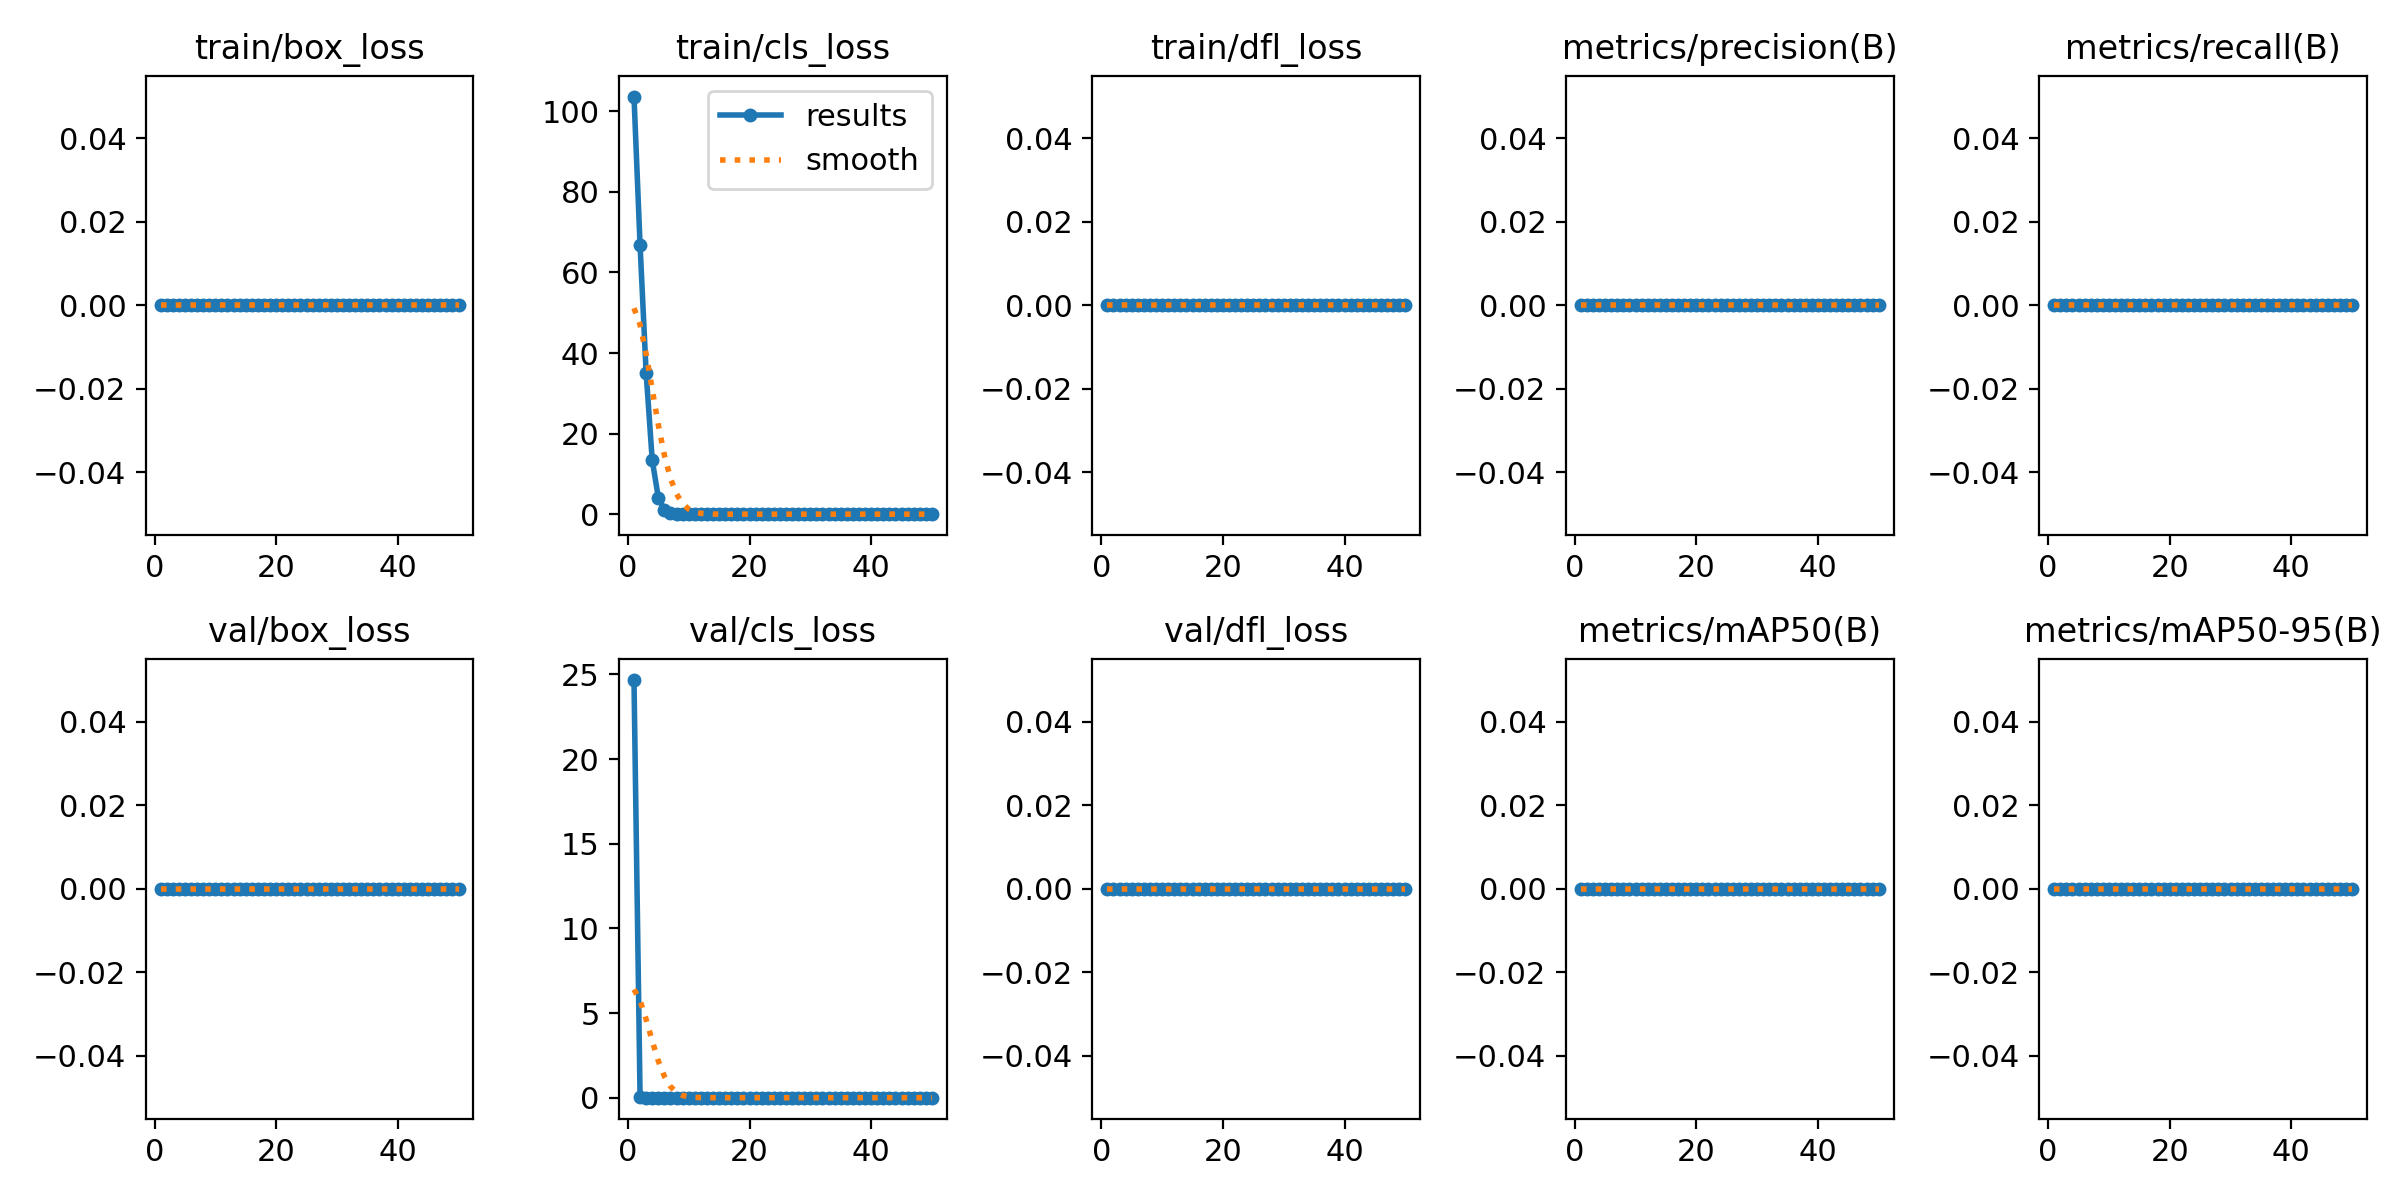

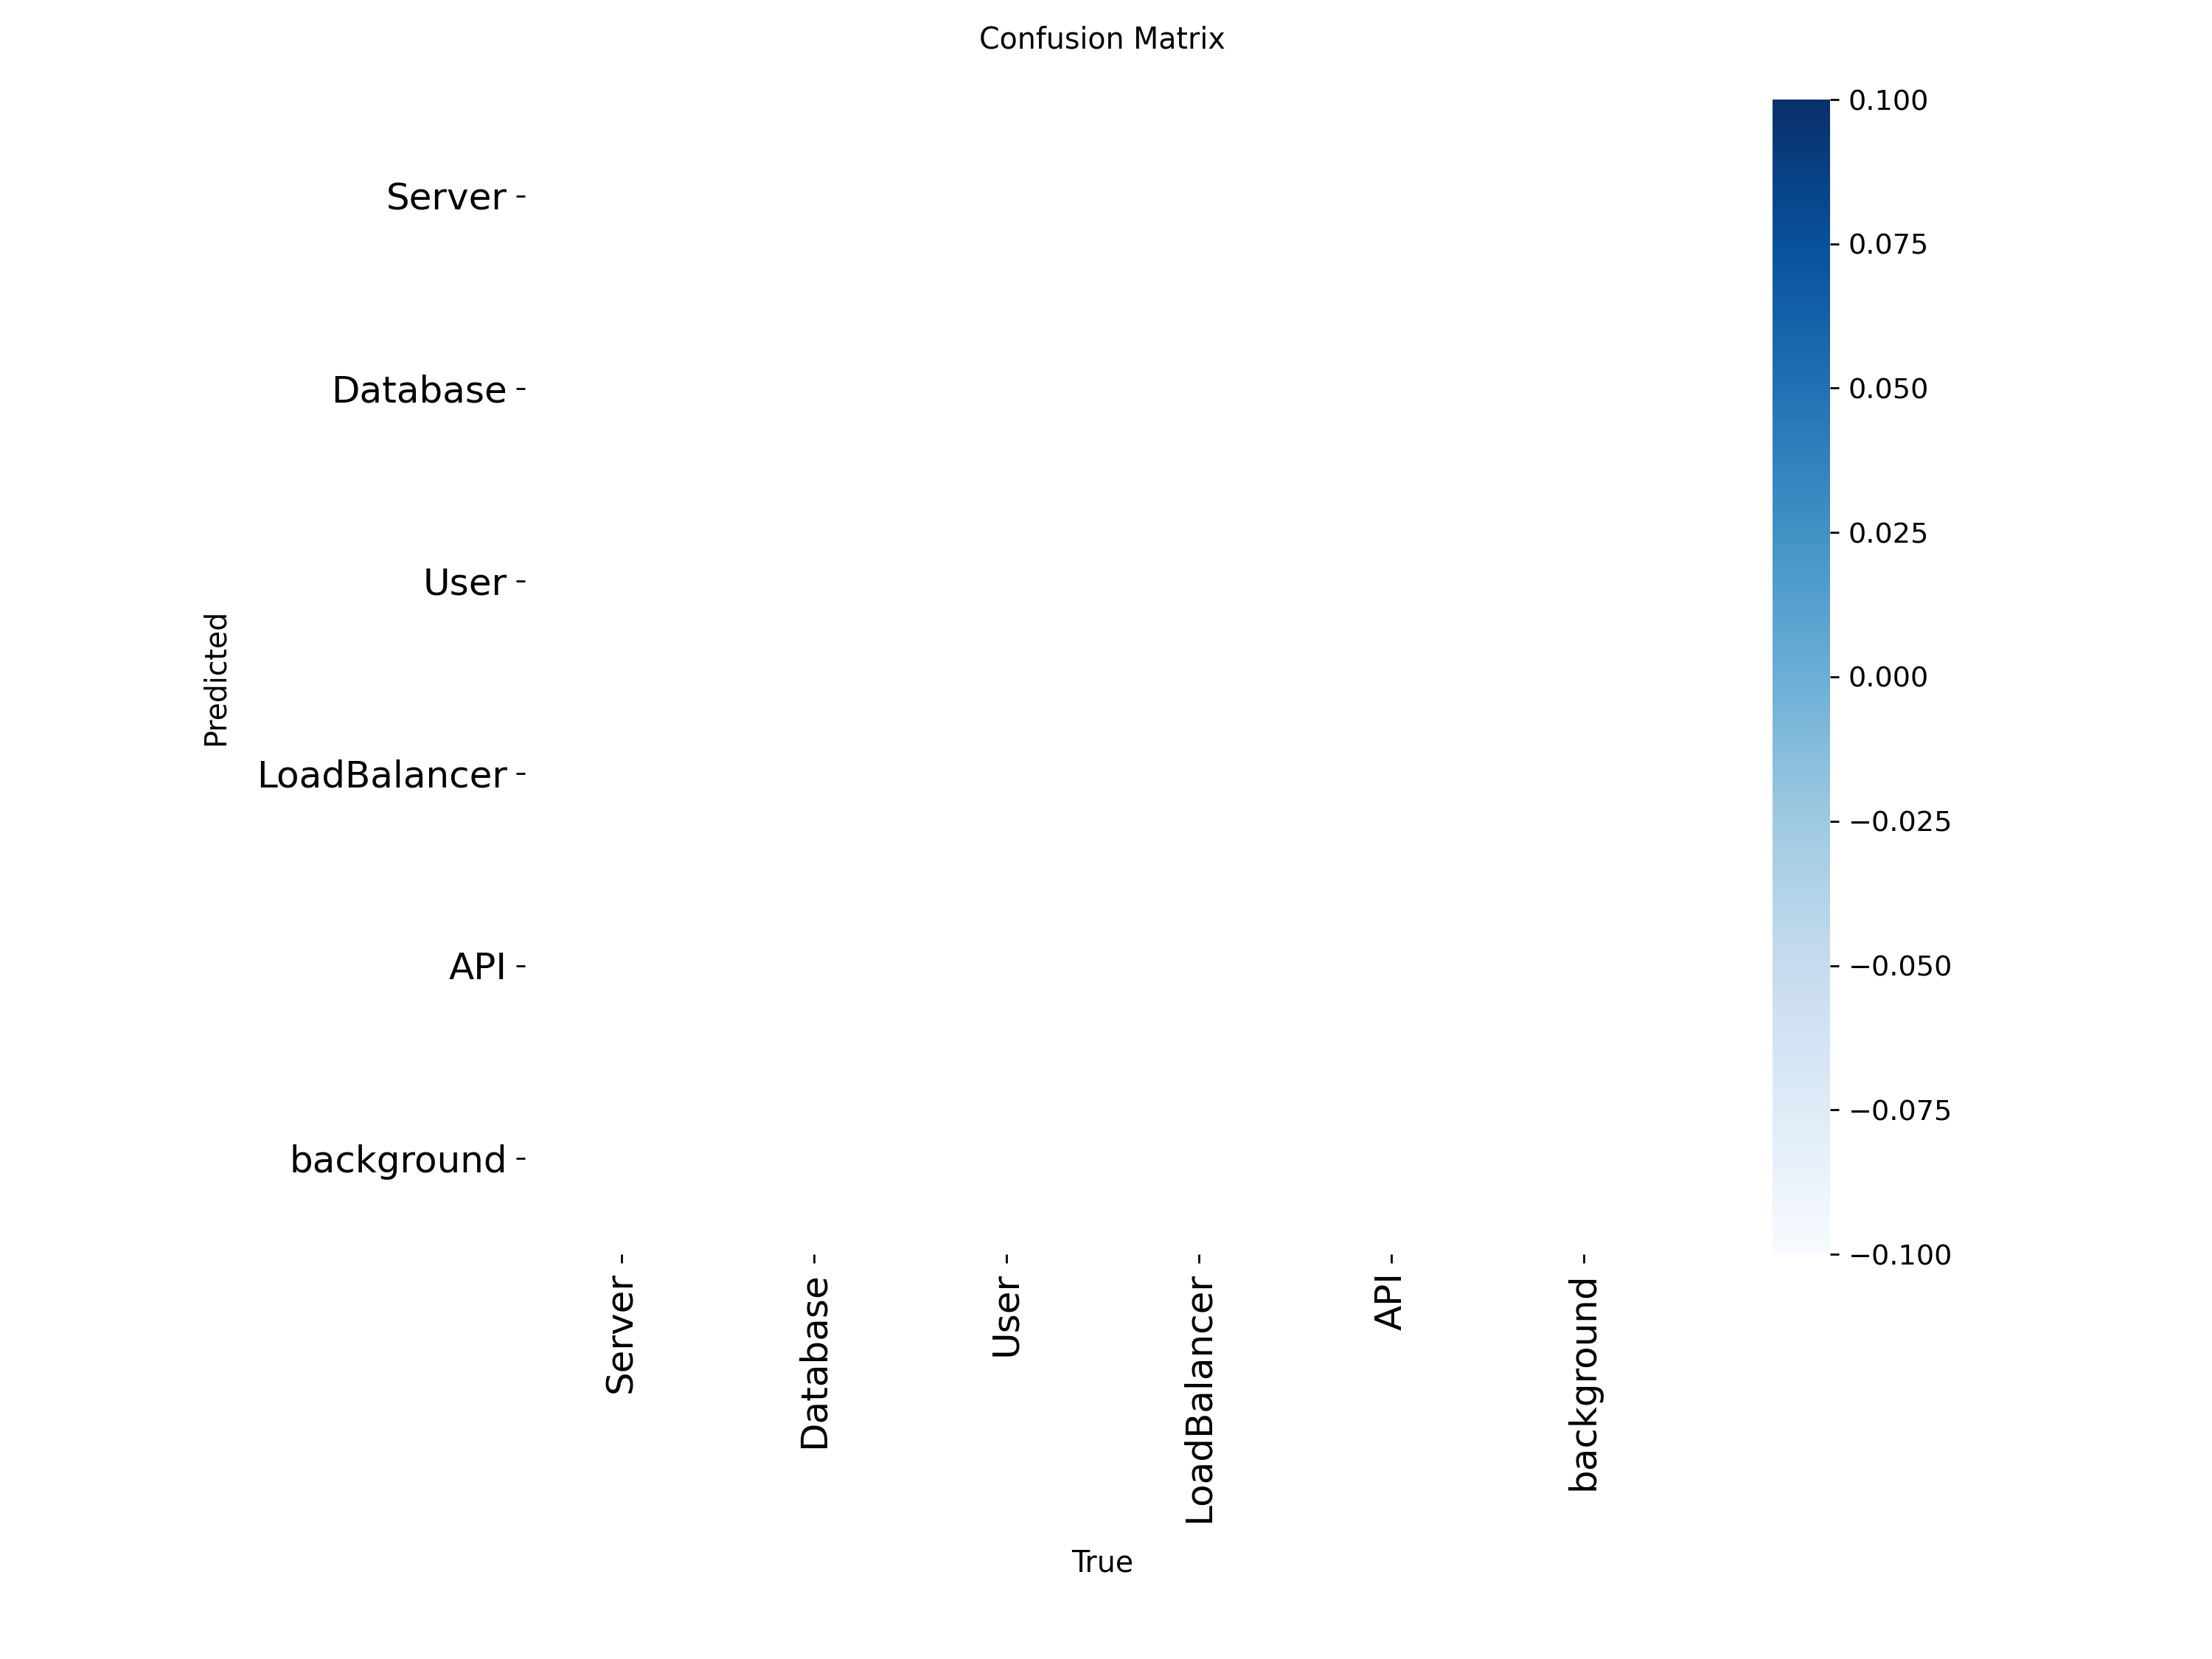

✅ Melhor modelo carregado: /content/drive/MyDrive/security_analysis/models/security_analysis_model2/weights/best.pt


In [24]:
# Visualizar resultados do treinamento
from IPython.display import Image, display

results_dir = os.path.join(MODELS_DIR, 'security_analysis_model2')

# Mostrar gráficos de loss e métricas
if os.path.exists(os.path.join(results_dir, 'results.png')):
    display(Image(os.path.join(results_dir, 'results.png')))

if os.path.exists(os.path.join(results_dir, 'confusion_matrix.png')):
    display(Image(os.path.join(results_dir, 'confusion_matrix.png')))

# Carregar melhor modelo treinado
best_model_path = os.path.join(results_dir, 'weights', 'best.pt')
if os.path.exists(best_model_path):
    trained_model = YOLO(best_model_path)
    print(f"✅ Melhor modelo carregado: {best_model_path}")
else:
    print("⚠️ Modelo não encontrado. Usando modelo base.")
    trained_model = model

## 5. Engine de Segurança - Análise STRIDE

In [25]:
# Definir ameaças STRIDE por componente
STRIDE_THREATS = {
    'Server': {
        'Spoofing': 'Autenticação de servidor pode ser falsificada',
        'Tampering': 'Dados no servidor podem ser modificados não autorizadamente',
        'Repudiation': 'Ações do servidor podem não ser registradas adequadamente',
        'Information Disclosure': 'Dados sensíveis podem ser expostos',
        'Denial of Service': 'Servidor pode ser sobrecarregado ou derrubado',
        'Elevation of Privilege': 'Ataque pode obter privilégios administrativos'
    },
    'Database': {
        'Spoofing': 'Conexões de banco de dados podem ser falsificadas',
        'Tampering': 'Dados podem ser modificados sem autorização',
        'Repudiation': 'Transações podem não ser auditadas',
        'Information Disclosure': 'Dados sensíveis podem ser acessados indevidamente',
        'Denial of Service': 'Banco pode ser sobrecarregado ou corrompido',
        'Elevation of Privilege': 'Acesso privilegiado pode ser obtido'
    },
    'User': {
        'Spoofing': 'Identidade do usuário pode ser falsificada',
        'Tampering': 'Dados do usuário podem ser modificados',
        'Repudiation': 'Ações do usuário podem ser negadas',
        'Information Disclosure': 'Informações pessoais podem ser expostas',
        'Denial of Service': 'Acesso do usuário pode ser bloqueado',
        'Elevation of Privilege': 'Usuário pode obter privilégios não autorizados'
    },
    'LoadBalancer': {
        'Spoofing': 'Tráfego pode ser redirecionado para servidores maliciosos',
        'Tampering': 'Configurações podem ser modificadas',
        'Repudiation': 'Logs de roteamento podem ser manipulados',
        'Information Disclosure': 'Padrões de tráfego podem ser expostos',
        'Denial of Service': 'Balanceador pode ser sobrecarregado',
        'Elevation of Privilege': 'Controle do balanceador pode ser obtido'
    },
    'API': {
        'Spoofing': 'Endpoints podem ser falsificados',
        'Tampering': 'Requisições podem ser modificadas',
        'Repudiation': 'Chamadas de API podem não ser auditadas',
        'Information Disclosure': 'Dados de API podem ser expostos',
        'Denial of Service': 'API pode ser sobrecarregada',
        'Elevation of Privilege': 'Acesso privilegiado à API pode ser obtido'
    }
}

# Contramedidas sugeridas
COUNTERMEASURES = {
    'Spoofing': [
        'Implementar autenticação forte (MFA, certificados)',
        'Usar TLS/SSL para comunicação',
        'Validar identidades com tokens JWT'
    ],
    'Tampering': [
        'Implementar checksums e assinaturas digitais',
        'Usar WAF (Web Application Firewall)',
        'Aplicar validação de entrada rigorosa'
    ],
    'Repudiation': [
        'Implementar logging completo e imutável',
        'Usar assinaturas digitais em transações críticas',
        'Manter auditoria de todas as ações'
    ],
    'Information Disclosure': [
        'Criptografar dados em repouso e em trânsito',
        'Implementar controle de acesso baseado em roles (RBAC)',
        'Aplicar princípio do menor privilégio'
    ],
    'Denial of Service': [
        'Implementar rate limiting e throttling',
        'Usar CDN e balanceamento de carga',
        'Configurar monitoramento e alertas'
    ],
    'Elevation of Privilege': [
        'Implementar separação de privilégios',
        'Validar permissões em cada requisição',
        'Usar princípio do menor privilégio'
    ]
}

In [26]:
# Instalar networkx se necessário (já instalado acima, mas garantindo)
!pip install networkx -q

import networkx as nx
from collections import defaultdict

def detect_components_and_build_graph(image_path, model):
    """
    Detecta componentes na imagem e constrói um grafo de arquitetura
    """
    results = model(image_path)

    components = []
    graph = nx.DiGraph()
    node_mapping = {}  # Mapear índice do componente para node_id

    for result in results:
        boxes = result.boxes
        for idx, box in enumerate(boxes):
            cls = int(box.cls[0])
            conf = float(box.conf[0])
            class_name = model.names[cls]

            # Obter coordenadas
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()

            component = {
                'class': class_name,
                'confidence': conf,
                'bbox': (x1, y1, x2, y2),
                'center': ((x1 + x2) / 2, (y1 + y2) / 2)
            }
            components.append(component)

            # Criar node_id único
            comp_idx = len(components)
            node_id = f"{class_name}_{comp_idx}"
            node_mapping[comp_idx - 1] = node_id  # Índice 0-based
            graph.add_node(node_id, **component)

    # Inferir conexões baseado na proximidade e tipo
    # User -> API -> Server -> Database
    for i, comp1 in enumerate(components):
        for j, comp2 in enumerate(components):
            if i != j:
                # Calcular distância entre centros
                dist = ((comp1['center'][0] - comp2['center'][0])**2 +
                       (comp1['center'][1] - comp2['center'][1])**2)**0.5

                # Regras de conexão heurísticas
                if dist < 300:  # Threshold de proximidade
                    node1 = node_mapping[i]
                    node2 = node_mapping[j]

                    # Definir direção baseada em tipos
                    if comp1['class'] == 'User' and comp2['class'] in ['API', 'LoadBalancer']:
                        graph.add_edge(node1, node2, type='user_request')
                    elif comp1['class'] in ['API', 'LoadBalancer'] and comp2['class'] == 'Server':
                        graph.add_edge(node1, node2, type='api_call')
                    elif comp1['class'] == 'Server' and comp2['class'] == 'Database':
                        graph.add_edge(node1, node2, type='data_access')
                    elif dist < 150:
                        graph.add_edge(node1, node2, type='connection')

    return components, graph, results[0].plot()

print("✅ Função de detecção e construção de grafo criada!")

✅ Função de detecção e construção de grafo criada!


In [27]:
def generate_stride_report(components, graph, image_path, output_path):
    """
    Gera relatório STRIDE completo baseado nos componentes detectados
    """
    from datetime import datetime

    report_lines = []
    report_lines.append("# Relatório de Análise de Segurança STRIDE\n")
    report_lines.append(f"**Data de Análise:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    report_lines.append(f"**Imagem Analisada:** {os.path.basename(image_path)}\n\n")

    report_lines.append("## Resumo Executivo\n")
    report_lines.append(f"- **Total de Componentes Detectados:** {len(components)}\n")

    # Contar componentes por tipo
    component_counts = defaultdict(int)
    for comp in components:
        component_counts[comp['class']] += 1

    report_lines.append("\n### Distribuição de Componentes\n")
    for comp_type, count in component_counts.items():
        report_lines.append(f"- **{comp_type}:** {count}\n")

    report_lines.append("\n## Análise STRIDE por Componente\n")

    # Analisar cada componente
    for idx, comp in enumerate(components, 1):
        comp_type = comp['class']
        conf = comp['confidence']

        report_lines.append(f"\n### {idx}. {comp_type} (Confiança: {conf:.2%})\n")

        # Obter ameaças STRIDE para este componente
        threats = STRIDE_THREATS.get(comp_type, STRIDE_THREATS.get('Server', {}))

        for threat_type, description in threats.items():
            report_lines.append(f"\n#### {threat_type}\n")
            report_lines.append(f"**Descrição:** {description}\n")

            # Adicionar contramedidas
            countermeasures = COUNTERMEASURES.get(threat_type, [])
            if countermeasures:
                report_lines.append("**Contramedidas Sugeridas:**\n")
                for cm in countermeasures:
                    report_lines.append(f"- {cm}\n")

    # Análise do grafo de arquitetura
    report_lines.append("\n## Análise de Arquitetura\n")
    report_lines.append(f"- **Total de Conexões:** {graph.number_of_edges()}\n")
    report_lines.append(f"- **Total de Nós:** {graph.number_of_nodes()}\n")

    # Identificar pontos críticos
    if graph.number_of_nodes() > 0:
        try:
            centrality = nx.degree_centrality(graph)
            sorted_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)

            report_lines.append("\n### Pontos Críticos (Alta Centralidade)\n")
            for node, cent in sorted_nodes[:5]:
                report_lines.append(f"- **{node}:** Centralidade {cent:.3f}\n")
        except:
            pass

    # Recomendações gerais
    report_lines.append("\n## Recomendações Gerais\n")
    report_lines.append("- Implementar monitoramento contínuo de segurança\n")
    report_lines.append("- Realizar testes de penetração regulares\n")
    report_lines.append("- Manter componentes atualizados com patches de segurança\n")
    report_lines.append("- Implementar backup e recuperação de desastres\n")
    report_lines.append("- Treinar equipe em práticas de segurança\n")

    # Salvar relatório
    report_content = ''.join(report_lines)

    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(report_content)

    print(f"✅ Relatório salvo em: {output_path}")
    return report_content

print("✅ Função de geração de relatório STRIDE criada!")

✅ Função de geração de relatório STRIDE criada!


In [28]:
# Networkx já instalado acima - esta célula pode ser ignorada se já executou a célula de instalação
# !pip install networkx -q
print("✅ Dependências de análise de grafo prontas!")

✅ Dependências de análise de grafo prontas!


## 6. Teste de Inferência e Geração de Relatório

🔍 Analisando imagem: /content/dataset/src/imagem2.png

image 1/1 /content/dataset/src/imagem2.png: 448x640 (no detections), 48.5ms
Speed: 2.9ms preprocess, 48.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


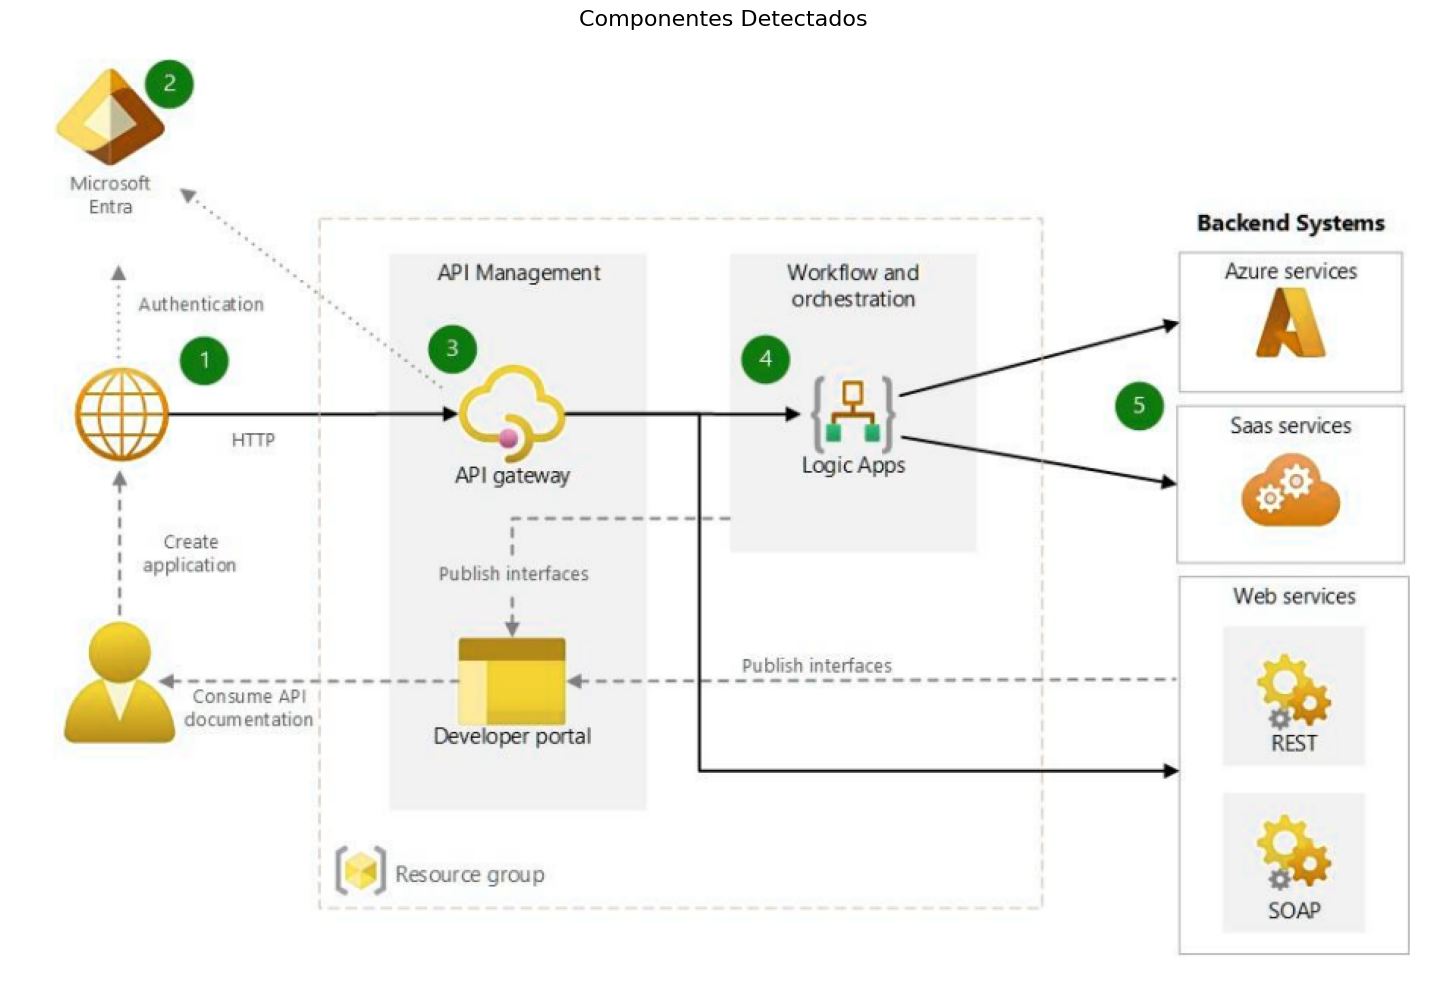

✅ Relatório salvo em: /content/drive/MyDrive/security_analysis/reports/stride_report_20260209_214128.md


# Relatório de Análise de Segurança STRIDE
**Data de Análise:** 2026-02-09 21:41:28
**Imagem Analisada:** imagem2.png

## Resumo Executivo
- **Total de Componentes Detectados:** 0

### Distribuição de Componentes

## Análise STRIDE por Componente

## Análise de Arquitetura
- **Total de Conexões:** 0
- **Total de Nós:** 0

## Recomendações Gerais
- Implementar monitoramento contínuo de segurança
- Realizar testes de penetração regulares
- Manter componentes atualizados com patches de segurança
- Implementar backup e recuperação de desastres
- Treinar equipe em práticas de segurança


In [36]:
# Testar inferência em uma imagem
import matplotlib.pyplot as plt
from datetime import datetime

# Encontrar uma imagem de teste
test_images = list(Path(DATA_DIR).rglob('*.jpg')) + list(Path(DATA_DIR).rglob('*.png'))
#print(test_images)
#test_images = list("/content/dataset/src/imagem1.png")

if test_images:
    test_image = str(test_images[0])
    print(f"🔍 Analisando imagem: {test_image}")

    # Detectar componentes
    components, graph, annotated_img = detect_components_and_build_graph(test_image, trained_model)

    # Visualizar resultado
    plt.figure(figsize=(15, 10))
    plt.imshow(annotated_img)
    plt.title('Componentes Detectados', fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(REPORTS_DIR, 'detection_result.png'), dpi=150)
    plt.show()

    # Gerar relatório
    report_path = os.path.join(REPORTS_DIR, f"stride_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.md")
    report_content = generate_stride_report(components, graph, test_image, report_path)

    # Exibir relatório
    from IPython.display import Markdown
    display(Markdown(report_content))
else:
    print("⚠️ Nenhuma imagem de teste encontrada")

## 7. Interface Gradio (Opcional)

In [37]:
import gradio as gr
import tempfile
from datetime import datetime

def analyze_security(image_file):
    """
    Função para interface Gradio
    """
    if image_file is None:
        return None, "Por favor, faça upload de uma imagem."

    try:
        # Detectar componentes
        components, graph, annotated_img = detect_components_and_build_graph(image_file.name, trained_model)

        # Salvar imagem anotada temporariamente
        temp_img_path = os.path.join(REPORTS_DIR, f"temp_annotated_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png")
        plt.imsave(temp_img_path, annotated_img)

        # Gerar relatório
        report_path = os.path.join(REPORTS_DIR, f"stride_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.md")
        report_content = generate_stride_report(components, graph, image_file.name, report_path)

        return temp_img_path, report_content
    except Exception as e:
        return None, f"Erro ao processar imagem: {str(e)}"

# Criar interface Gradio
iface = gr.Interface(
    fn=analyze_security,
    inputs=gr.Image(type="filepath", label="Upload Diagrama de Arquitetura"),
    outputs=[
        gr.Image(label="Imagem com Detecções"),
        gr.Textbox(label="Relatório STRIDE", lines=20)
    ],
    title="🔒 Análise de Segurança Automatizada (AIOps)",
    description="Faça upload de um diagrama de arquitetura para análise de segurança usando STRIDE",
    theme="default"
)

# Lançar interface
iface.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://62fb243577f398e0df.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://62fb243577f398e0df.gradio.live


## 8. Exportar Modelo e Salvar Estado

In [38]:
# Salvar modelo treinado no Google Drive
if os.path.exists(best_model_path):
    import shutil
    final_model_path = os.path.join(MODELS_DIR, 'final_model.pt')
    shutil.copy(best_model_path, final_model_path)
    print(f"✅ Modelo final salvo em: {final_model_path}")

# Criar arquivo de resumo
summary = f"""
# Resumo do Pipeline de Análise de Segurança

## Arquivos Importantes:
- Modelo Treinado: {MODELS_DIR}/final_model.pt
- Relatórios: {REPORTS_DIR}/
- Dataset: {DATA_DIR}/

## Próximos Passos:
1. Testar o modelo com novas imagens
2. Ajustar hiperparâmetros se necessário
3. Expandir classes de componentes detectados
4. Melhorar análise STRIDE com regras mais específicas
"""

with open(os.path.join(WORK_DIR, 'README.md'), 'w') as f:
    f.write(summary)

print("✅ Estado do projeto salvo!")

✅ Modelo final salvo em: /content/drive/MyDrive/security_analysis/models/final_model.pt
✅ Estado do projeto salvo!
